In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0532.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0282.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1401.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0914.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0691.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0972.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0818.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0463.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0930.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1323.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1347.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1354.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0704.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0

In [3]:
import os
import time
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers


In [4]:
# Paths
root = '/kaggle/input/brain-tumor-mri-dataset'
train_dir = os.path.join(root, 'Training')
test_dir = os.path.join(root, 'Testing')

# Parameters
target_size = (150, 150)
batch_size = 32
num_classes = 4

In [5]:
def get_files_and_labels(directory):
    file_paths = []
    labels = []
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            for file in os.listdir(class_dir):
                file_paths.append(os.path.join(class_dir, file))
                labels.append(class_name)
    return file_paths, labels

train_files, train_labels = get_files_and_labels(train_dir)

train_files, val_files, train_labels, val_labels = train_test_split(
    train_files, 
    train_labels, 
    test_size=0.2, 
    stratify=train_labels,
    random_state=42
)

train_df = pd.DataFrame({'filename': train_files, 'class': train_labels})
val_df = pd.DataFrame({'filename': val_files, 'class': val_labels})

In [6]:
train_df

,filename,class
0,/kaggle/input/brain-tumor-mri-dataset/Training...,meningioma
1,/kaggle/input/brain-tumor-mri-dataset/Training...,notumor
2,/kaggle/input/brain-tumor-mri-dataset/Training...,glioma
3,/kaggle/input/brain-tumor-mri-dataset/Training...,meningioma
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
...,...,...
4564,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4565,/kaggle/input/brain-tumor-mri-dataset/Training...,notumor
4566,/kaggle/input/brain-tumor-mri-dataset/Training...,notumor
4567,/kaggle/input/brain-tumor-mri-dataset/Training...,meningioma


In [7]:
val_df

,filename,class
0,/kaggle/input/brain-tumor-mri-dataset/Training...,meningioma
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,meningioma
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,notumor
...,...,...
1138,/kaggle/input/brain-tumor-mri-dataset/Training...,notumor
1139,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1140,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1141,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary


In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    brightness_range=(0.85, 1.15),
)

val_datagen = ImageDataGenerator(rescale=1./255) 
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='class',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Important for evaluation
)

print(f'Train samples: {len(train_generator)} batches (~{len(train_df)} images)')
print(f'Validation samples: {len(val_generator)} batches (~{len(val_df)} images)')
print(f'Test samples: {len(test_generator)} batches (~{test_generator.samples} images)')

Found 4569 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Train samples: 143 batches (~4569 images)
Validation samples: 36 batches (~1143 images)
Test samples: 41 batches (~1311 images)


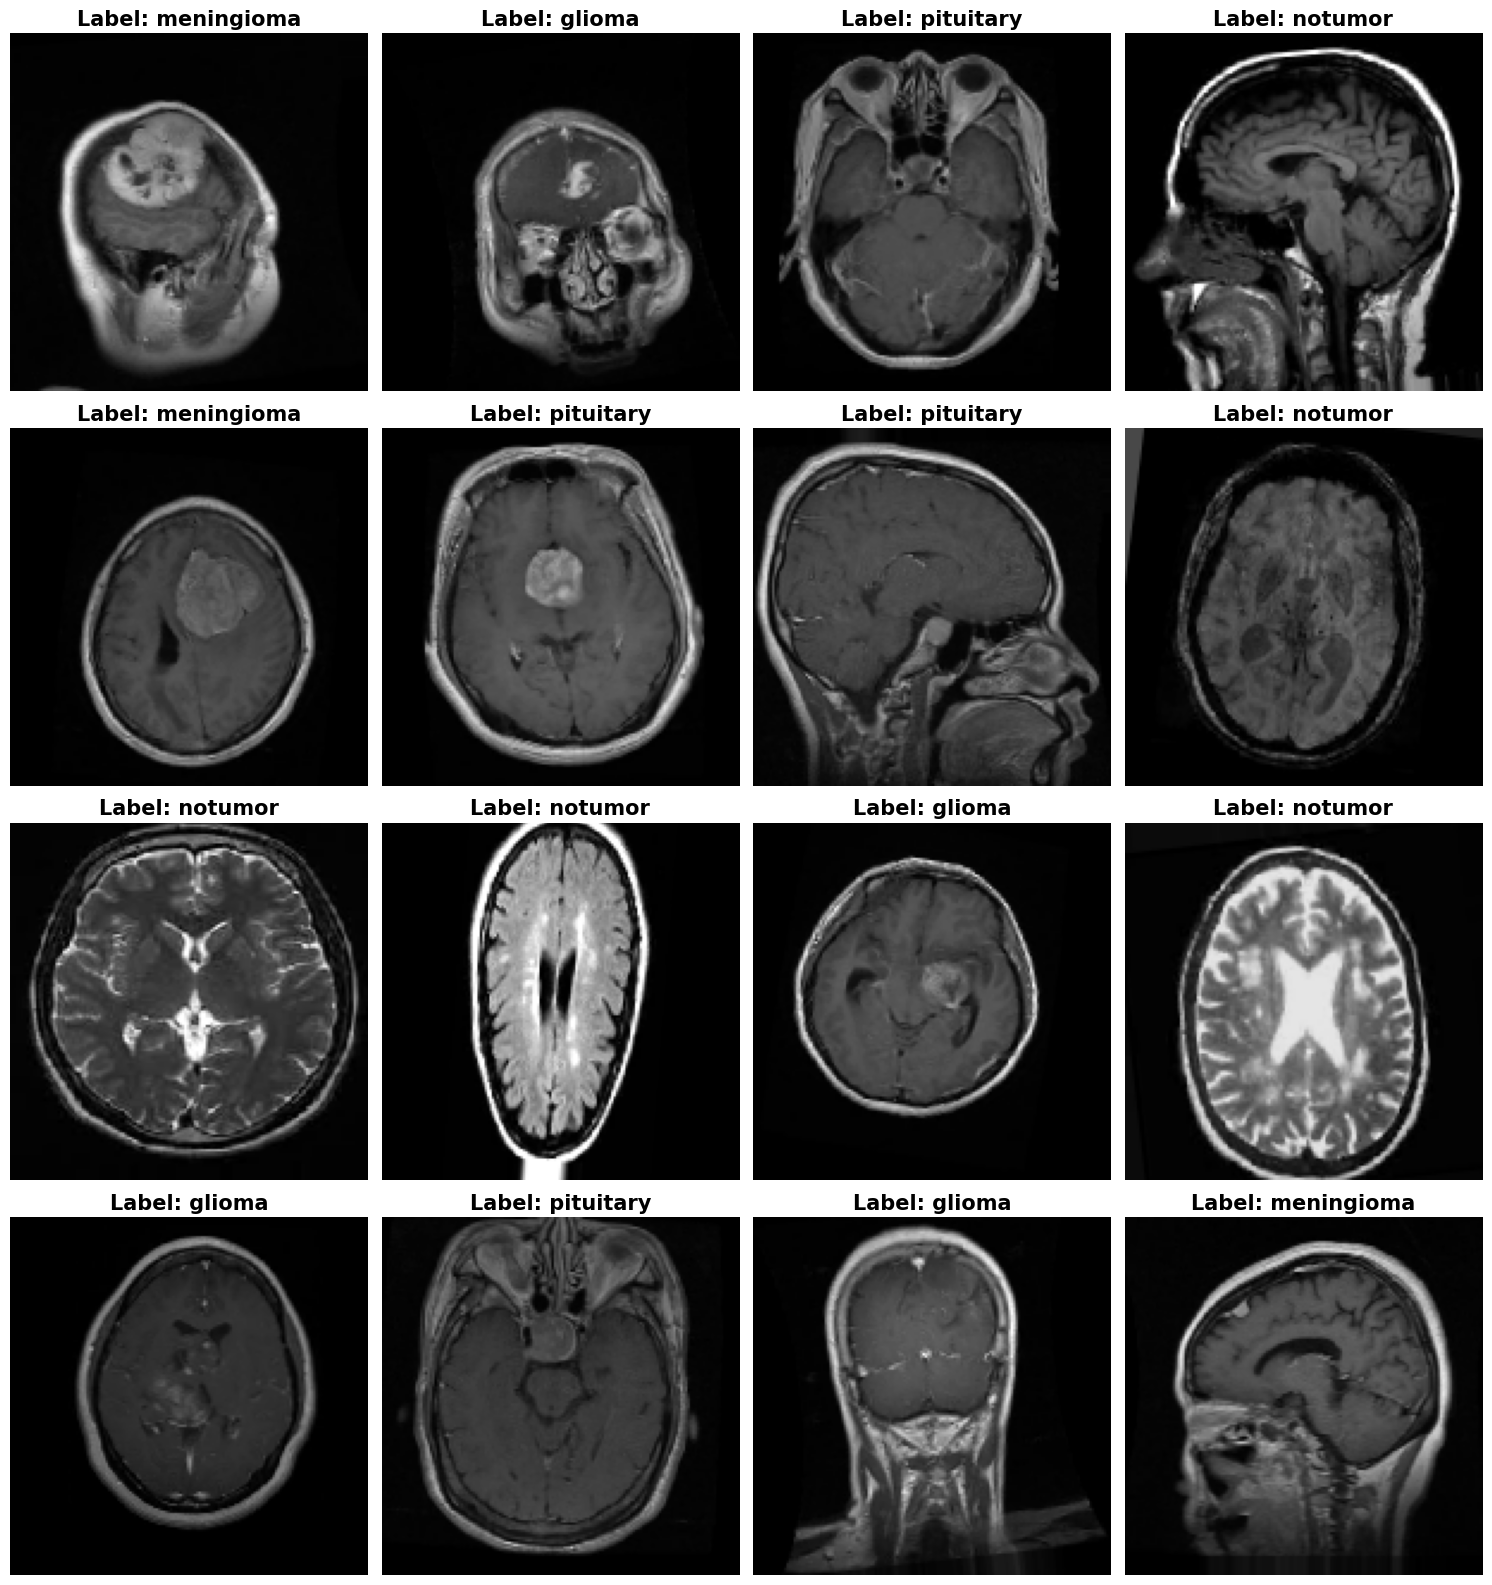

In [9]:
images, labels = next(train_generator) 

images = images * 255 
images = np.clip(images, 0, 255).astype('uint8')

# Get class names from the generator
class_names = list(train_generator.class_indices.keys())

# Plot configuration
num_images = min(len(images), 16)  # Show up to 16 images
rows = 4
fig, axes = plt.subplots(rows, 4, figsize=(15, 4 * rows))

for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(images[i])
        ax.set_title(f'Label: {class_names[np.argmax(labels[i])]}',
                    fontsize=15, fontweight='bold')
        ax.axis('off')

# Hide empty subplots
for ax in axes.flat[num_images:]:
    ax.axis('off')

plt.tight_layout(pad=1)
plt.show()

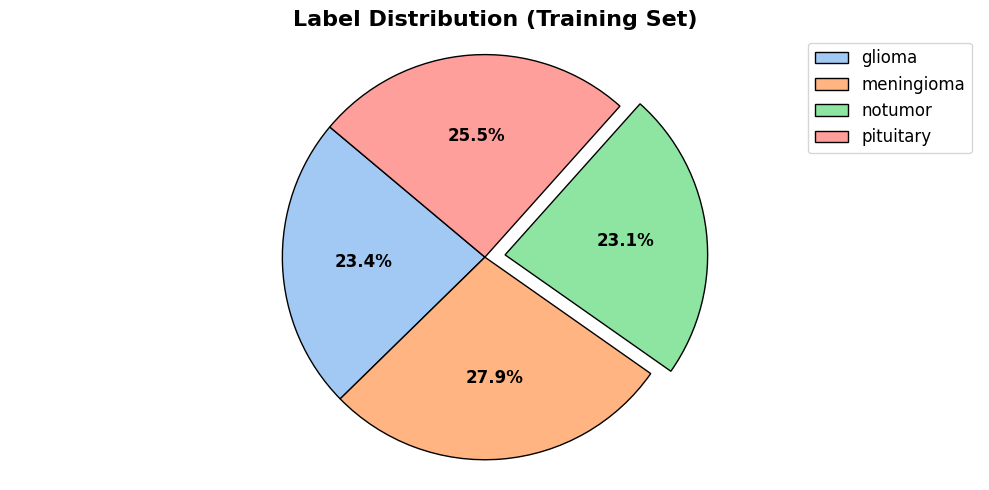

In [10]:
from collections import defaultdict

train_label_counts = defaultdict(int)
for label in train_df['class']:
    train_label_counts[label] += 1

class_names = list(train_generator.class_indices.keys())
sizes_train = list(train_label_counts.values())

fig, ax = plt.subplots(figsize=(10, 5))
wedges_train, texts_train, autotexts_train = ax.pie(
    sizes_train,
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('pastel'),
    wedgeprops=dict(edgecolor='black'),
    explode=[0.1 if i == 2 else 0 for i in range(len(class_names))]  # Explode 3rd slice
)

ax.set_title('Label Distribution (Training Set)', fontsize=16, fontweight='bold')
ax.axis('equal')
ax.legend(wedges_train, class_names, loc='best', fontsize=12)

# Style the text
for text in texts_train:
    text.set_fontsize(12)
    text.set_fontweight('bold')

for autotext in autotexts_train:
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

In [12]:
model = models.Sequential([
    layers.Conv2D(32, (4, 4), strides=(1, 1), padding='same', activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(pool_size=(3, 3)),

    layers.Conv2D(64, (4, 4), strides=(1, 1), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(3, 3)),

    layers.Conv2D(128, (4, 4), strides=(1, 1), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(3, 3)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])


In [13]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 150, 150, 32)        │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 50, 50, 64)          │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       1,638,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,806,564 (6.89 MB)

 Trainable params: 1,806,564 (6.89 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

checkpoint_cb = ModelCheckpoint(
    filepath='best_brainTumor_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

reduce_lr_cb = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=5,
    verbose=1
)

early_stop_cb = EarlyStopping(
    monitor='val_loss',
    patience=10, 
    restore_best_weights=True, 
    verbose=1
)

In [17]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[checkpoint_cb, reduce_lr_cb, early_stop_cb]
)

Epoch 1/30


I0000 00:00:1748949132.233661     696 service.cc:148] XLA service 0x7ccba4844e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748949132.233699     696 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748949132.233704     696 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748949132.492223     696 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/143 ━━━━━━━━━━━━━━━━━━━━ 11:29 5s/step - accuracy: 0.1875 - loss: 1.3886 - precision: 0.0000e+00 - recall: 0.0000e+00

I0000 00:00:1748949135.537104     696 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.5088 - loss: 1.0448 - precision: 0.6478 - recall: 0.3022
Epoch 1: val_loss improved from inf to 0.62211, saving model to best_brainTumor_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 44s 278ms/step - accuracy: 0.5096 - loss: 1.0433 - precision: 0.6484 - recall: 0.3035 - val_accuracy: 0.7664 - val_loss: 0.6221 - val_precision: 0.7930 - val_recall: 0.7305 - learning_rate: 0.0010
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.7822 - loss: 0.5623 - precision: 0.8078 - recall: 0.7384
Epoch 2: val_loss improved from 0.62211 to 0.43456, saving model to best_brainTumor_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 34s 240ms/step - accuracy: 0.7822 - loss: 0.5621 - precision: 0.8079 - recall: 0.7385 - val_accuracy: 0.8460 - val_loss: 0.4346 - val_precision: 0.8742 - val_recall: 0.8084 - learning_rate: 0.0010
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.8207 - loss: 0.4722 - precision: 0.8454 - recall: 0.7

In [18]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 150, 150, 32)        │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 50, 50, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 50, 50, 64)          │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       1,638,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,419,694 (20.67 MB)

 Trainable params: 1,806,564 (6.89 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,613,130 (13.78 MB)

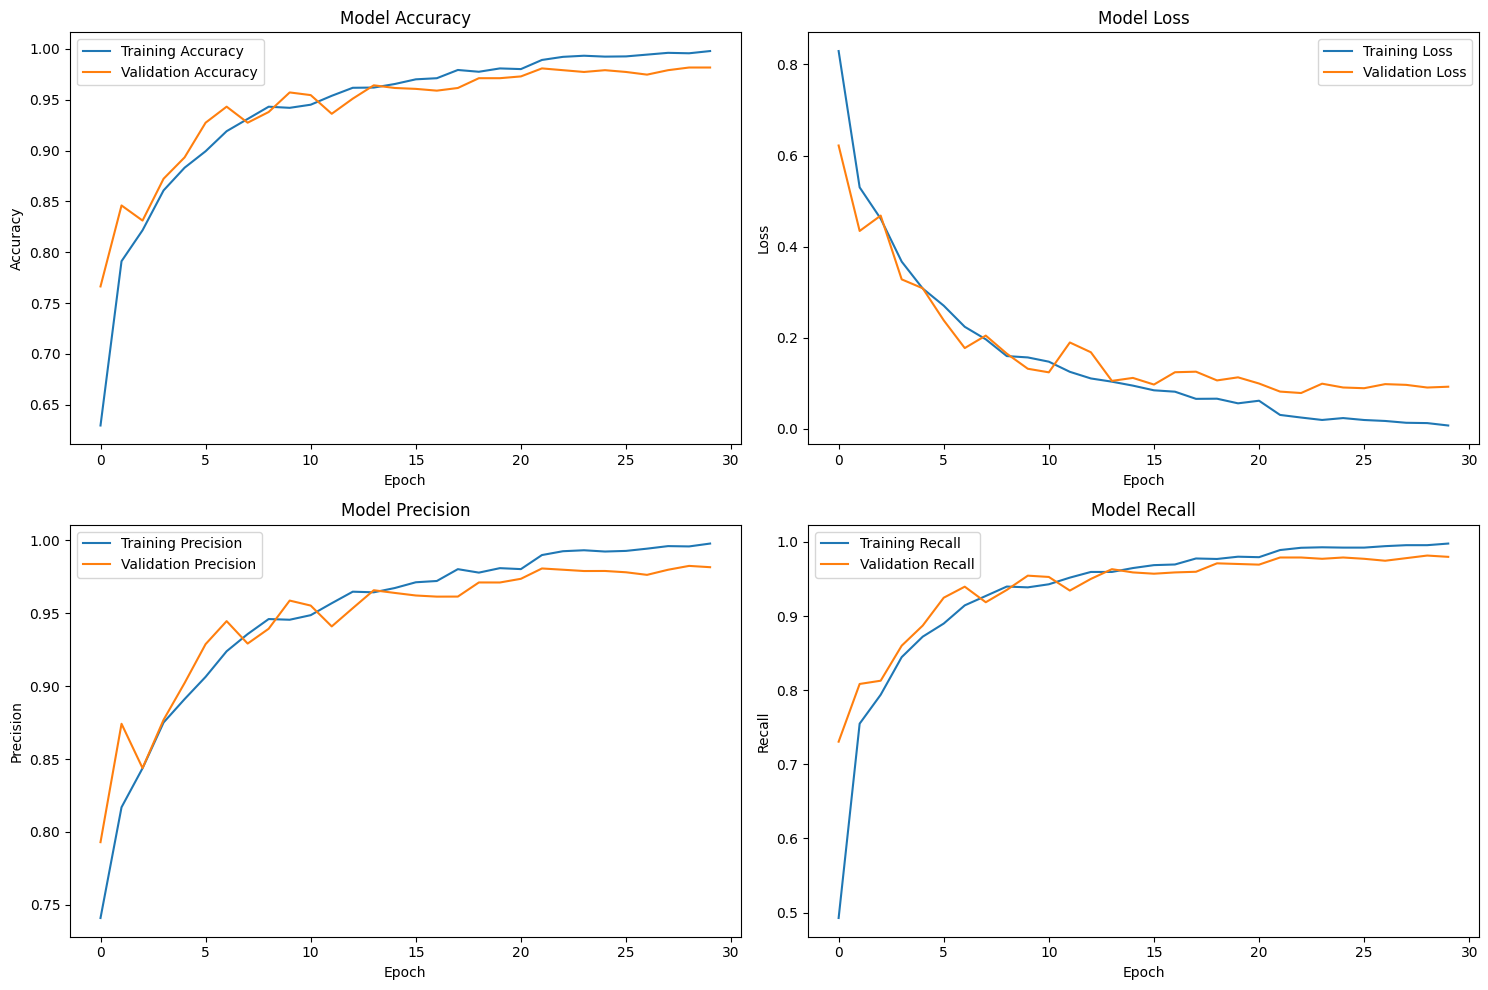

In [19]:
import matplotlib.pyplot as plt

# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0, 0].set_title('Model Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()

# Loss
axes[0, 1].plot(history.history['loss'], label='Training Loss')
axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 1].set_title('Model Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()

# Precision
axes[1, 0].plot(history.history['precision'], label='Training Precision')
axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
axes[1, 0].set_title('Model Precision')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()

# Recall
axes[1, 1].plot(history.history['recall'], label='Training Recall')
axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
axes[1, 1].set_title('Model Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 276ms/step
Test Accuracy: 97.79%
------------------------------------------------------------
CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

      glioma     0.9671    0.9800    0.9735       300
  meningioma     0.9761    0.9346    0.9549       306
     notumor     0.9951    0.9951    0.9951       405
   pituitary     0.9676    0.9967    0.9819       300

    accuracy                         0.9779      1311
   macro avg     0.9765    0.9766    0.9764      1311
weighted avg     0.9780    0.9779    0.9778      1311



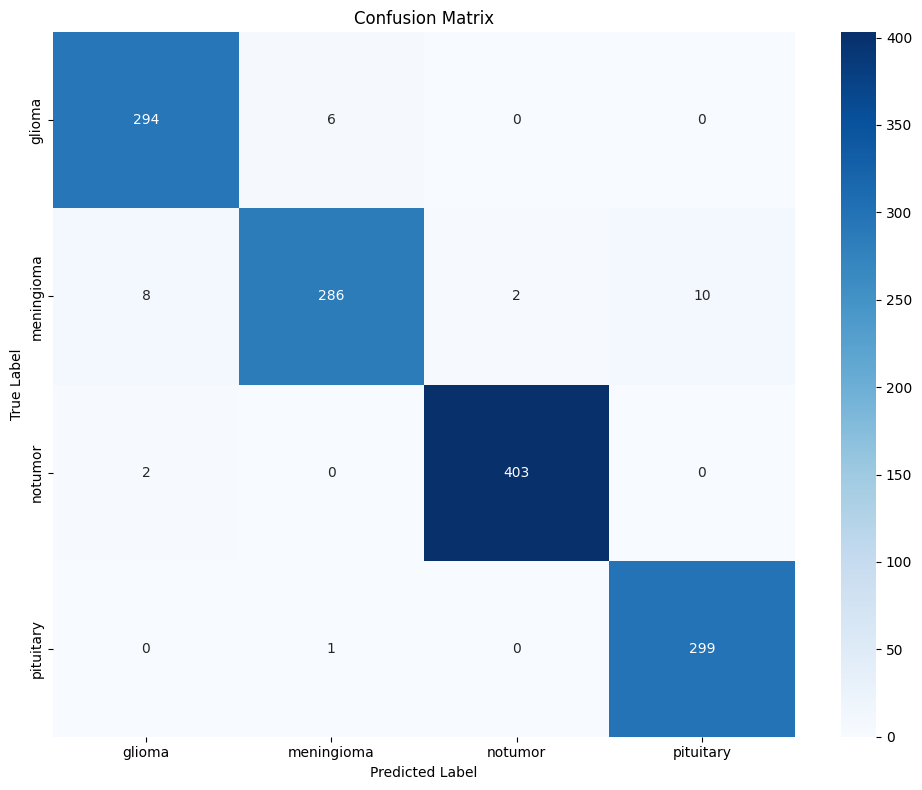

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

test_generator.reset()

test_predictions = model.predict(test_generator, verbose=1)
test_pred_classes = np.argmax(test_predictions, axis=1)

test_true_classes = test_generator.classes
class_names = list(test_generator.class_indices.keys())

test_accuracy = accuracy_score(test_true_classes, test_pred_classes)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Classification report
print("-"*60)
print("CLASSIFICATION REPORT")
print("-"*60)
print(classification_report(test_true_classes, test_pred_classes, target_names=class_names, digits=4))

# Confusion matrix
cm = confusion_matrix(test_true_classes, test_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


In [22]:
import tensorflow as tf

best_model = tf.keras.models.load_model("/kaggle/working/best_brainTumor_model.keras")

converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

# Save to file
with open("BrainTumor_model.tflite", "wb") as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmp7faq_efj'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  137217698984400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137217698987280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137217698987664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137217698986896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137217698986704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137217698985936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137217698987472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137217698984976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137217297688016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137217297683024: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1748952108.354867     649 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1748952108.354904     649 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1748952108.361625     649 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
